In [11]:
import numpy as np
import MITgcmutils
import matplotlib.pyplot as plt
from utils.resample_to_latlon import resample_to_latlon
from utils.utils import conversion
from glob import glob

path_grid = "ECCO2/LLC270/ECCO-Darwin_extension/grid"
path_3d = "ECCO2/LLC270/ECCO-Darwin_extension/budget/average_DIC_3d"
path_2d = "ECCO2/LLC270/ECCO-Darwin_extension/budget/average_2d"

#### Variable list

In [2]:
fldList_3d = ['TRAC01','ADVxTr01','ADVyTr01','ADVrTr01','DFxETr01','DFyETr01','DFrETr01',
              'DFrITr01','gDAR01','cDIC','cDIC_PIC','respDIC','rDIC_DOC','rDIC_POC','dDIC_PIC']
fldList_2d = ['ETAN','oceFWflx','SFLUX','TFLUX','oceSPflx','oceQsw','fluxCO2','gDICsurf',
           'gDICEpr','gALKEpr','gNO3Epr','gNO2Epr','gNH4Epr','gO2Epr','gPO4Epr','gFeTEpr','gSiO2Epr']

mapping_3d = list(zip(range(len(fldList_3d)),fldList_3d))
mapping_2d = list(zip(range(len(fldList_2d)),fldList_2d))

variable_selection_2d = [6,8]
variable_selection_3d = [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14]


display(mapping_3d)
print()
display(mapping_2d)

variable_names = [mapping_3d[idx][1] for idx in variable_selection_3d] + [mapping_2d[idx][1] for idx in variable_selection_2d]

[(0, 'TRAC01'),
 (1, 'ADVxTr01'),
 (2, 'ADVyTr01'),
 (3, 'ADVrTr01'),
 (4, 'DFxETr01'),
 (5, 'DFyETr01'),
 (6, 'DFrETr01'),
 (7, 'DFrITr01'),
 (8, 'gDAR01'),
 (9, 'cDIC'),
 (10, 'cDIC_PIC'),
 (11, 'respDIC'),
 (12, 'rDIC_DOC'),
 (13, 'rDIC_POC'),
 (14, 'dDIC_PIC')]

[(0, 'ETAN'),
 (1, 'oceFWflx'),
 (2, 'SFLUX'),
 (3, 'TFLUX'),
 (4, 'oceSPflx'),
 (5, 'oceQsw'),
 (6, 'fluxCO2'),
 (7, 'gDICsurf'),
 (8, 'gDICEpr'),
 (9, 'gALKEpr'),
 (10, 'gNO3Epr'),
 (11, 'gNO2Epr'),
 (12, 'gNH4Epr'),
 (13, 'gO2Epr'),
 (14, 'gPO4Epr'),
 (15, 'gFeTEpr'),
 (16, 'gSiO2Epr')]

#### importing data

In [5]:
d_2 = MITgcmutils.mds.rdmds(f"{path_2d}/average_2d.0000002232",rec=variable_selection_2d)
d_3 = MITgcmutils.mds.rdmds(f"{path_3d}/average_DIC_3d.0000002232",rec=variable_selection_3d)

# getting the grid details
depth_c = MITgcmutils.mds.rdmds(f"{path_grid}/RC")
depth_f = MITgcmutils.mds.rdmds(f"{path_grid}/RF")
lon = MITgcmutils.mds.rdmds(f"{path_grid}/XC")
lat = MITgcmutils.mds.rdmds(f"{path_grid}/YC")
dxc = MITgcmutils.mds.rdmds(f"{path_grid}/DXC")
dyc = MITgcmutils.mds.rdmds(f"{path_grid}/DYC")
hfacc = MITgcmutils.mds.rdmds(f"{path_grid}/hFacC")

lon_g = MITgcmutils.mds.rdmds(f"{path_grid}/XG")
lat_g = MITgcmutils.mds.rdmds(f"{path_grid}/YG")

# Calculating delta depth
drc = np.diff(depth_c, axis=0) * -1
drc = drc[:,0,0]

drf = np.diff(depth_f, axis=0) * -1
drf = drf[:,0,0]

#### Conversion

In [7]:
# convert 3D variables
for var_idx in range(13):
    d_3[var_idx] = conversion(d_3[var_idx],variable_names[var_idx],dxc=dxc,dyc=dyc,drf=drf,hfacc=hfacc)

# convert 2D variables
for var_idx in range(2):
    d_2[var_idx] = conversion(d_2[var_idx],variable_names[13+var_idx],dxc=dxc,dyc=dyc,drf=drf,hfacc=hfacc)
    

#### Flatten 3d data

In [8]:
# getting index of top 100m depth
idx_top_100m = np.where(depth_c>=-100)[0]

# Using numpy
delta_depth_f_vec = drf[idx_top_100m, np.newaxis, np.newaxis]
flattened_d3 = np.sum(delta_depth_f_vec * d_3[:,idx_top_100m,:,:], axis=1)/100 # Compressing the depth into 2D for top 100m

#### Combine and process variables

In [9]:
# combine data
combined_data = np.concatenate((flattened_d3, d_2), axis=0)

# create a mask for land mass to subtract from everything. using combined_data[0] (TRAC01) for mask
mask = combined_data[0]==0
combined_data[:,mask] = np.nan

# Interpolating the curvilinear line to the cartesian plane
new_grid_delta_lat, new_grid_delta_lon = 0.5, 0.5
new_grid_min_lat, new_grid_max_lat = -90, 90
new_grid_min_lon, new_grid_max_lon = -180, 180
new_shape = (combined_data.shape[0],
             int((new_grid_max_lat - new_grid_min_lat)/new_grid_delta_lat),
             int(((new_grid_max_lon - new_grid_min_lon)/new_grid_delta_lon)))

variables_cart = np.empty(new_shape)

for variable in range(combined_data.shape[0]):  
    lon_cart,lat_cart,_,_,variables_cart[variable] = \
                                resample_to_latlon(lon,lat,combined_data[variable],
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
                                fill_value = np.NaN,
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)
                                                                         
variables_cart.shape

(15, 360, 720)

#### plotting

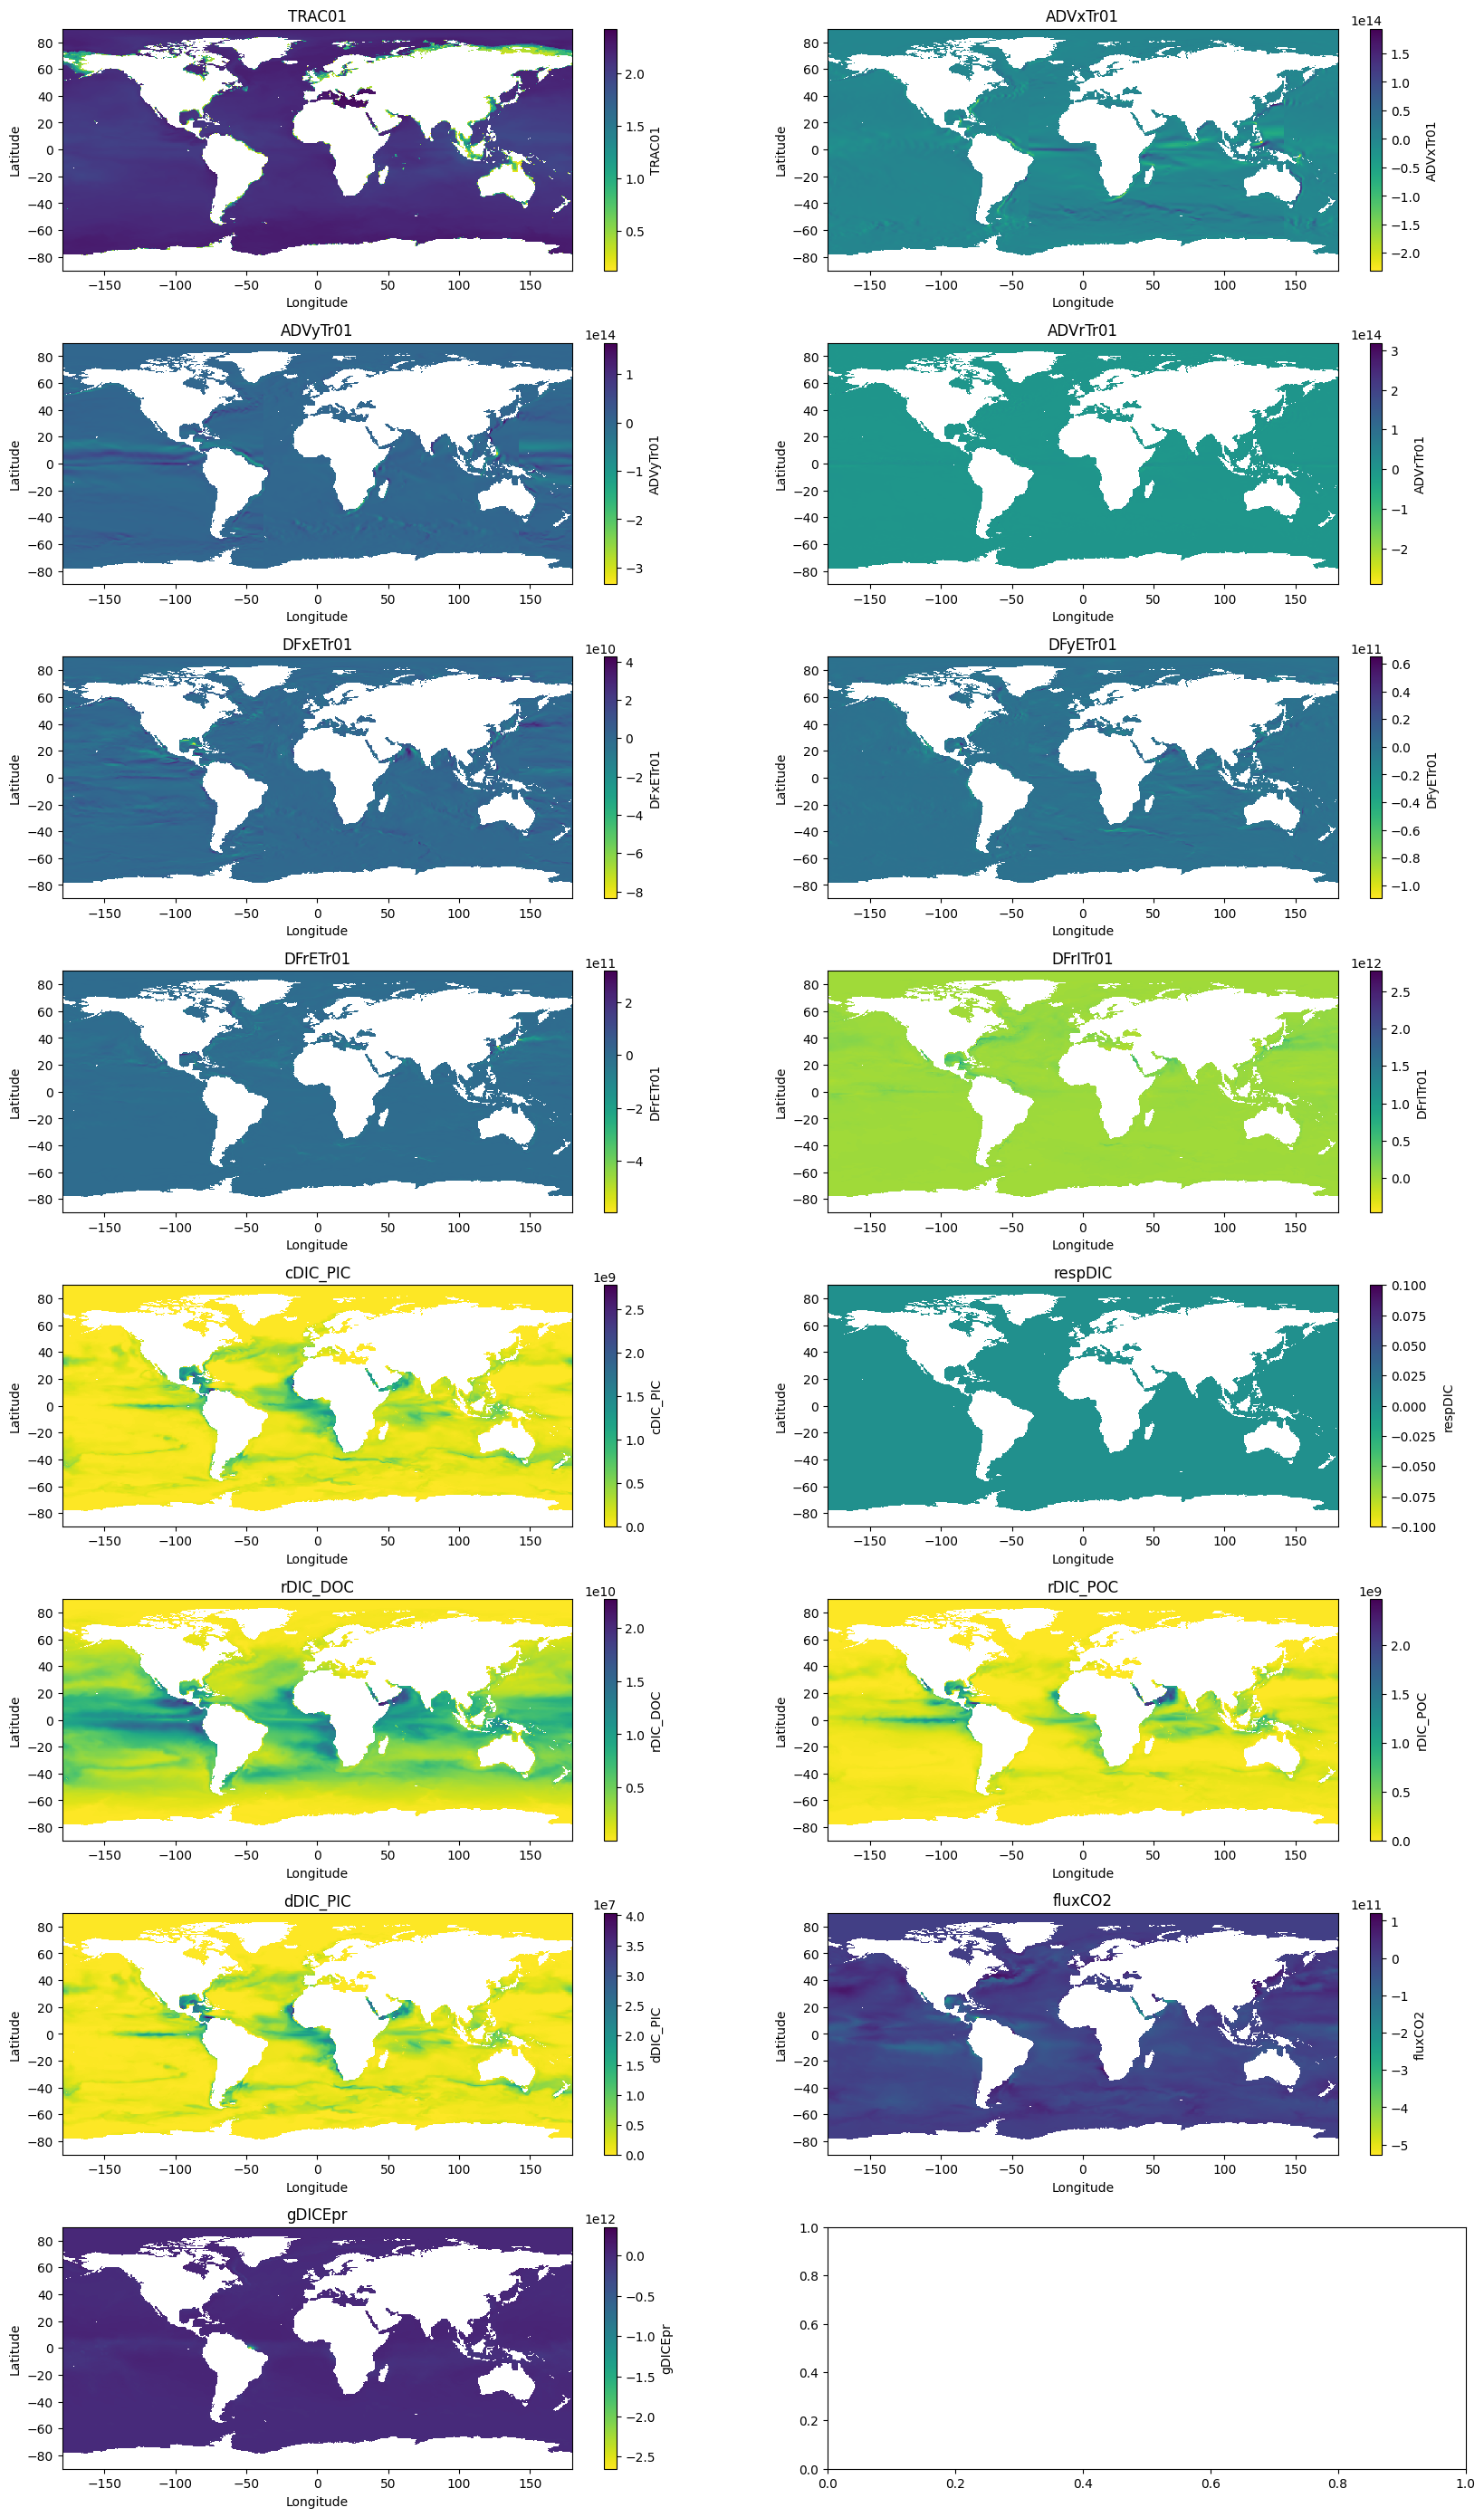

In [29]:
# pcolormesh
fig, axes = plt.subplots(8, 2, figsize=(20, 35))  # Adjust figsize for clarity
axes = axes.flatten()  # Flatten axes for easier indexing

# Iterate through all variables
for var_idx, var_name in enumerate(variable_names):
    ax = axes[var_idx]
    values = variables_cart_sum_timesteps[var_idx]/3  # Color values for the current variable

    # pcolormesh for the current variable
    pcolor = ax.pcolormesh(lon_cart,lat_cart, values, cmap='viridis_r', shading='auto')
    cbar = plt.colorbar(pcolor, ax=ax)
    cbar.set_label(var_name)

    # Add labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{var_name}')
    plt.subplots_adjust(hspace=0.3)

# plt.savefig("compressed and converted.png", dpi=300, bbox_inches="tight")
plt.show()

#### Integrating accross timestep

In [15]:
variables_cart_sum_timesteps = np.zeros(shape=variables_cart.shape)
variables_cart_sum_timesteps.shape

(15, 360, 720)

In [25]:
# getting the grid details
depth_c = MITgcmutils.mds.rdmds(f"{path_grid}/RC")
depth_f = MITgcmutils.mds.rdmds(f"{path_grid}/RF")
lon = MITgcmutils.mds.rdmds(f"{path_grid}/XC")
lat = MITgcmutils.mds.rdmds(f"{path_grid}/YC")
dxc = MITgcmutils.mds.rdmds(f"{path_grid}/DXC")
dyc = MITgcmutils.mds.rdmds(f"{path_grid}/DYC")
hfacc = MITgcmutils.mds.rdmds(f"{path_grid}/hFacC")

lon_g = MITgcmutils.mds.rdmds(f"{path_grid}/XG")
lat_g = MITgcmutils.mds.rdmds(f"{path_grid}/YG")

# Calculating delta depth
drc = np.diff(depth_c, axis=0) * -1
drc = drc[:,0,0]

drf = np.diff(depth_f, axis=0) * -1
drf = drf[:,0,0]


timestep_list = [path.split(".")[1] for path in glob(f"{path_2d}/*.data")]
timestep_list.sort()

# Initialize sum
variables_cart_sum_timesteps = np.zeros(shape=variables_cart.shape)

for i,timestep in enumerate(timestep_list[0:3]):
    print(f"Started running for time step: {timestep}")
    # import 2d and 3d variables ==========================================================================
    d_2 = MITgcmutils.mds.rdmds(f"{path_2d}/average_2d.{timestep}",rec=variable_selection_2d)
    d_3 = MITgcmutils.mds.rdmds(f"{path_3d}/average_DIC_3d.{timestep}",rec=variable_selection_3d)
    # =========================================================================================================

    # Conversion ===============================================================================================
    # convert 3D variables into standard units
    for var_idx in range(13):
        d_3[var_idx] = conversion(d_3[var_idx],variable_names[var_idx],dxc=dxc,dyc=dyc,drf=drf,hfacc=hfacc)
    
    # convert 2D variables into standard units
    for var_idx in range(2):
        d_2[var_idx] = conversion(d_2[var_idx],variable_names[13+var_idx],dxc=dxc,dyc=dyc,drf=drf,hfacc=hfacc)
    # =========================================================================================================

    # FLattening ==============================================================================================
    # Flatten 3D variables upto 100m
    idx_top_100m = np.where(depth_c>=-100)[0] # getting index of top 100m depth
    
    # Integrate across Depth=====================================================================================
    delta_depth_f_vec = drf[idx_top_100m, np.newaxis, np.newaxis]
    flattened_d3 = np.sum(delta_depth_f_vec * d_3[:,idx_top_100m,:,:], axis=1)/100 # Compressing the depth into 2D for top 100m
    # ===========================================================================================================
    
    # Conversion into Cratesian grid ============================================================================
    combined_data = np.concatenate((flattened_d3, d_2), axis=0) # combine data
    
    # create a mask for land mass to subtract from everything. using combined_data[0] (TRAC01) for mask
    mask = combined_data[0]==0
    combined_data[:,mask] = np.nan
    
    # Interpolating the curvilinear line to the cartesian plane
    new_grid_delta_lat, new_grid_delta_lon = 0.5, 0.5
    new_grid_min_lat, new_grid_max_lat = -90, 90
    new_grid_min_lon, new_grid_max_lon = -180, 180
    new_shape = (combined_data.shape[0],
                 int((new_grid_max_lat - new_grid_min_lat)/new_grid_delta_lat),
                 int(((new_grid_max_lon - new_grid_min_lon)/new_grid_delta_lon)))
    
    variables_cart = np.empty(new_shape)
    
    for variable in range(combined_data.shape[0]):  
        lon_cart,lat_cart,_,_,variables_cart[variable] = \
                                    resample_to_latlon(lon,lat,combined_data[variable],
                                    new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
                                    new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
                                    fill_value = np.NaN,
                                    mapping_method = 'nearest_neighbor',
                                    radius_of_influence = 120000)
    # =======================================================================================================

    variables_cart_sum_timesteps = variables_cart_sum_timesteps + variables_cart

# variables_cart_final = variables_cart_sum_timesteps/i



Started running for time step: 0000002232
Started running for time step: 0000004320
Started running for time step: 0000006552


In [27]:
variables_cart_sum_timesteps

(15, 360, 720)

In [36]:
meta_list = [MITgcmutils.mds.rdmds(f"{path_2d}/average_2d.{timestep}",rec=variable_selection_2d,returnmeta=True)[2] 
             for timestep in timestep_list]

378

In [43]:
meta_list[0]

{'ndims': [2],
 'dataprec': ['float32'],
 'nrecords': [17],
 'missingvalue': [-999.0],
 'nflds': [17],
 'fldlist': ['ETAN',
  'oceFWflx',
  'SFLUX',
  'TFLUX',
  'oceSPflx',
  'oceQsw',
  'fluxCO2',
  'gDICsurf',
  'gDICEpr',
  'gALKEpr',
  'gNO3Epr',
  'gNO2Epr',
  'gNH4Epr',
  'gO2Epr',
  'gPO4Epr',
  'gFeTEpr',
  'gSiO2Epr'],
 'dimlist': [270, 3510],
 'timestepnumber': [2232],
 'timeinterval': [[2635200.0, 2678400.0]]}

In [56]:
timestep_range[0][1] - timestep_range[0][0]

43200.0

In [61]:
np.diff(np.array(timestep_num_list))[0:]


array([2088, 2232, 2160, 2232, 2160, 2232, 2232, 2160, 2232, 2160, 2232,
       2232, 2016, 2232, 2160, 2232, 2160, 2232, 2232, 2160, 2232, 2160,
       2232, 2232, 2016, 2232, 2160, 2232, 2160, 2232, 2232, 2160, 2232,
       2160, 2232, 2232, 2016, 2232, 2160, 2232, 2160, 2232, 2232, 2160,
       2232, 2160, 2232, 2232, 2088, 2232, 2160, 2232, 2160, 2232, 2232,
       2160, 2232, 2160, 2232, 2232, 2016, 2232, 2160, 2232, 2160, 2232,
       2232, 2160, 2232, 2160, 2232, 2232, 2016, 2232, 2160, 2232, 2160,
       2232, 2232, 2160, 2232, 2160, 2232, 2232, 2016, 2232, 2160, 2232,
       2160, 2232, 2232, 2160, 2232, 2160, 2232, 2232, 2088, 2232, 2160,
       2232, 2160, 2232, 2232, 2160, 2232, 2160, 2232, 2232, 2016, 2232,
       2160, 2232, 2160, 2232, 2232, 2160, 2232, 2160, 2232, 2232, 2016,
       2232, 2160, 2232, 2160, 2232, 2232, 2160, 2232, 2160, 2232, 2232,
       2016, 2232, 2160, 2232, 2160, 2232, 2232, 2160, 2232, 2160, 2232,
       2232, 2088, 2232, 2160, 2232, 2160, 2232, 22

In [50]:
timestep_num_list = [int(meta["timestepnumber"][0]) for meta in meta_list]
timestep_range = [meta["timeinterval"][0] for meta in meta_list]
timestep_range

[[2635200.0, 2678400.0],
 [2635200.0, 5184000.0],
 [5270400.0, 7862400.0],
 [7905600.0, 10454400.0],
 [10540800.0, 13132800.0],
 [13176000.0, 15724800.0],
 [15811200.0, 18403200.0],
 [18446400.0, 21081600.0],
 [21081600.0, 23673600.0],
 [23716800.0, 26352000.0],
 [26352000.0, 28944000.0],
 [28987200.0, 31622400.0],
 [34257600.0, 34300800.0],
 [34257600.0, 36720000.0],
 [36892800.0, 39398400.0],
 [39528000.0, 41990400.0],
 [42163200.0, 44668800.0],
 [44798400.0, 47260800.0],
 [47433600.0, 49939200.0],
 [50068800.0, 52617600.0],
 [52704000.0, 55209600.0],
 [55339200.0, 57888000.0],
 [57974400.0, 60480000.0],
 [60609600.0, 63158400.0],
 [63244800.0, 65836800.0],
 [65880000.0, 68256000.0],
 [68515200.0, 70934400.0],
 [71150400.0, 73526400.0],
 [73785600.0, 76204800.0],
 [76420800.0, 78796800.0],
 [79056000.0, 81475200.0],
 [81691200.0, 84153600.0],
 [84326400.0, 86745600.0],
 [86961600.0, 89424000.0],
 [89596800.0, 92016000.0],
 [92232000.0, 94694400.0],
 [94867200.0, 97372800.0],
 [975024

In [32]:
with open("ECCO2/LLC270/ECCO-Darwin_extension/budget/average_2d/average_2d.0000002232.meta") as f:
    print(f.read())

 nDims = [   2 ];
 dimList = [
   270,    1,  270,
  3510,    1, 3510
 ];
 dataprec = [ 'float32' ];
 nrecords = [         17 ];
 timeStepNumber = [       2232 ];
 timeInterval = [  2.635200000000E+06  2.678400000000E+06 ];
 missingValue = [ -9.99000000000000E+02 ];
 nFlds = [   17 ];
 fldList = {
 'ETAN    ' 'oceFWflx' 'SFLUX   ' 'TFLUX   ' 'oceSPflx' 'oceQsw  ' 'fluxCO2 ' 'gDICsurf' 'gDICEpr ' 'gALKEpr ' 'gNO3Epr ' 'gNO2Epr ' 'gNH4Epr ' 'gO2Epr  ' 'gPO4Epr ' 'gFeTEpr ' 'gSiO2Epr'
 };



#### Excel Test

In [58]:
drc = d_3[1]
variable_1_flattened = variable_1_data.reshape(variable_1_data.shape[0], -1)  # Shape: (50, 949770)

# Combine delta depth values with the flattened data
combined_data = np.column_stack((drf, variable_1_flattened))

# Convert to DataFrame for better Excel formatting
column_names = ['Delta Depth'] + [f'Value_{i}' for i in range(variable_1_flattened.shape[1])]
df_excel = pd.DataFrame(combined_data, columns=column_names).T

# Save to Excel
excel_path = "variable_1_depth_comparison.xlsx"
df_excel.to_excel(excel_path, index=False)
